# Running SATURN

This notebook will demonstrate how to run SATURN and review the output files.

Make sure to run through `dataloader.ipynb` first.

First, make the run csv file.

It should have format:

|path|species|embedding path|
|-----|------|--------------|
|path to frog|frog|frog embeddings path|
|path to zebrafish|zebrafish|zebrafish embeddings path|

In [1]:
# Make the csv
import pandas as pd

df = pd.DataFrame(columns=["path", "species", "embedding_path"])
df["species"] = ["frog", "zebrafish"]
df["path"] = ["data/frog.h5ad", "data/zebrafish.h5ad"]

##### CHANGE THESE PATHS #####
frog_embedding_path = "/dfs/project/cross-species/yanay/data/proteome/embeddings/Xenopus_tropicalis.Xenopus_tropicalis_v9.1.gene_symbol_to_embedding_ESM2.pt"
zebrafish_embedding_path = "/dfs/project/cross-species/yanay/data/proteome/embeddings/Danio_rerio.GRCz11.gene_symbol_to_embedding_ESM2.pt"
##############################
df["embedding_path"] = [frog_embedding_path, zebrafish_embedding_path]
df.to_csv("data/frog_zebrafish_run.csv", index=False)
df

,path,species,embedding_path
0,data/frog.h5ad,frog,/dfs/project/cross-species/yanay/data/proteome...
1,data/zebrafish.h5ad,zebrafish,/dfs/project/cross-species/yanay/data/proteome...


# Scoring while training

We will score our model output while training. To do that, we will need a scoring csv file. We have provided one in this dataset at `data/frog_zebrafish_cell_type_map.csv`. It looks like this:

In [2]:
pd.read_csv("data/frog_zebrafish_cell_type_map.csv").head(10)

,Unnamed: 0,frog_cell_type,zebrafish_cell_type
0,0,Blastula,NaN
1,1,Germline,Germline
2,2,Neuroectoderm,Neuroectoderm
3,3,Non-neural ectoderm,Non-neural ectoderm
4,4,Involuting marginal zone,Involuting marginal zone
5,5,Spemann organizer,NaN
6,6,Endoderm,Endoderm
7,7,Epidermal progenitor,Epidermal progenitor
8,8,Ionocyte,Ionocyte
9,9,Goblet cell,NaN


# Train the Model

We can see `train-saturn.py`'s potential arguments with `--help`.

In [3]:
!python3 ../../train-saturn.py --help

Global seed set to 0
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
usage: train-saturn.py [-h] [--in_data IN_DATA] [--device DEVICE]
                       [--device_num DEVICE_NUM] [--time_stamp TIME_STAMP]
                       [--org ORG] [--log_dir LOG_DIR] [--work_dir WORK_DIR]
                       [--seed SEED] [--in_label_col IN_LABEL_COL]
                       [--ref_label_col REF_LABEL_COL]
                       [--tissue_subset TISSUE_SUBSET]
                       [--tissue_column TISSUE_COLUMN] [--hv_genes HV_GENES]
                       [--hv_span HV_SPAN] [--num_macrogenes NUM_MACROGENES]
                       [--centroids_init_path CENTROIDS_INIT_PATH]
                       [--embedding_model {ESM1b,MSA1b,protXL,ESM1b_protref,ESM2}]
                       [--vae [VAE]] [--hidden_dim HIDDEN_DIM]
                       [--model_dim MODEL_DIM]
                       [--binarize_expression [BINARIZE_EXPRESSION]]
        

We'll train SATURN with the following settings:

|Argument|Value|Explanation|
|--------|-----|-----------|
|in_data|`data/frog_zebrafish_run.csv`|The csv we created containing paths.|
|in_label_col|`cell_type`|Use the `cell_type` column labels for metric learning. **NOTE:** SATURN is weakly supervised, it does not share cell type labels across species, so you don't need to match these values across AnnDatas.|
|ref_label_col|`cell_type`|Extra cell type argument, will be added to our output but won't effect results since we didn't add `--use_ref_labels|
|num_macrogenes|`2000`|By default, we use 2000 macrogenes.|
|hv_genes|`8000`|By default, we use the 8000 most highly variable genes.|
|centroids_init_path|`saturn_results/fz_centroids.pkl`|Since this is the first time we are runinng this command, we will have to initialize our macrogenes using KMeans, which is an expensive operation. We save that initialization to this location so that if we pass this path to this argument in future runs, we can skip that step.|
|score_adata||By adding this flag, we will score our adatas after pretraining and while fine tuning with metric learning.|
|ct_map_path|`data/frog_zebrafish_cell_type_map.csv`|The path to our cell type mapping file, needed since we are scoring while training.|
|work_dir|`./`|SATURN outputs to a folder called `saturn_results`.|

SATURN is very verbose. Some things to check during model training:
- Do the AnnData views printed at the start have enough genes? These AnnData views are output after subsetting your input AnnDatas to just the genes that have protein embeddings.


**This command may take some time.**

GPU Memory usage: ~8GB for Pretraining, ~10GB total for metric learning but this may very.

In [6]:
!python3 ../../train-saturn.py --in_data=data/frog_zebrafish_run.csv \
                              --in_label_col=cell_type --ref_label_col=cell_type \
                              --num_macrogenes=2000     --hv_genes=8000          \
                              --centroids_init_path=saturn_results/fz_centroids.pkl \
                              --score_adata --ct_map_path=data/frog_zebrafish_cell_type_map.csv \
                              --work_dir=. \
                              --device_num=7 \

Global seed set to 0
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Using Device 7
Set seed to 0
After loading the anndata frog View of AnnData object with n_obs × n_vars = 96935 × 9538
    obs: 'clusters', 'parent_clusters', 'cell_type', 'n_genes', 'species', 'species_type_label', 'truth_labels', 'ref_labels'
    var: 'n_cells'
After loading the anndata zebrafish View of AnnData object with n_obs × n_vars = 63371 × 16980
    obs: 'n_counts', 'unique_cell_id', 'cell_names', 'library_id', 'batch', 'ClusterID', 'ClusterName', 'TissueID', 'TissueName', 'TimeID', 'cluster', 'cell_type', 'n_genes', 'species', 'species_type_label', 'truth_labels', 'ref_labels'
    var: 'n_cells'
Loaded centroids
Pretraining...
Epoch 200: L1 Loss 0.0 Rank Loss 12.439830780029297, Avg Loss frog: 1862, Avg Lo
Saving Pretrain AnnData
100%|█████████████████████████████████████████| 157/157 [00:20<00:00,  7.74it/s]
*****PRETRAIN SCORES*****
-------------------------
--

# Analyze SATURN Outputs

Let's check what files SATURN outputted:

In [7]:
!ls ./saturn_results

fz_centroids.pkl
test256_data_frog_zebrafish_org_saturn_seed_0_celltype_id.pkl
test256_data_frog_zebrafish_org_saturn_seed_0_ep_25.h5ad
test256_data_frog_zebrafish_org_saturn_seed_0_ep_50.h5ad
test256_data_frog_zebrafish_org_saturn_seed_0_epoch_scores.csv
test256_data_frog_zebrafish_org_saturn_seed_0_genes_to_macrogenes.pkl
test256_data_frog_zebrafish_org_saturn_seed_0.h5ad
test256_data_frog_zebrafish_org_saturn_seed_0_pretrain.h5ad
test256_data_frog_zebrafish_org_saturn_seed_0_triplets.csv


We have a number of log files and 
- our output AnnData: `test256_data_frog_zebrafish_org_saturn_seed_0.h5ad`
- out ouput gene to macrogene weights: `test256_data_frog_zebrafish_org_saturn_seed_0_genes_to_macrogenes.pkl`

## Load SATURN Results

In [8]:
import scanpy as sc
import pickle

In [9]:
adata = sc.read("saturn_results/test256_data_frog_zebrafish_org_saturn_seed_0.h5ad")
adata

AnnData object with n_obs × n_vars = 160306 × 256
    obs: 'labels', 'labels2', 'ref_labels', 'species'
    obsm: 'macrogenes'

## Visualize our integration

In [10]:
sc.pp.pca(adata)

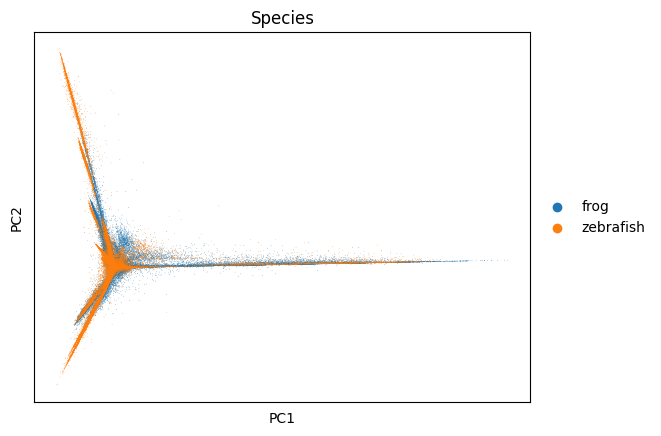

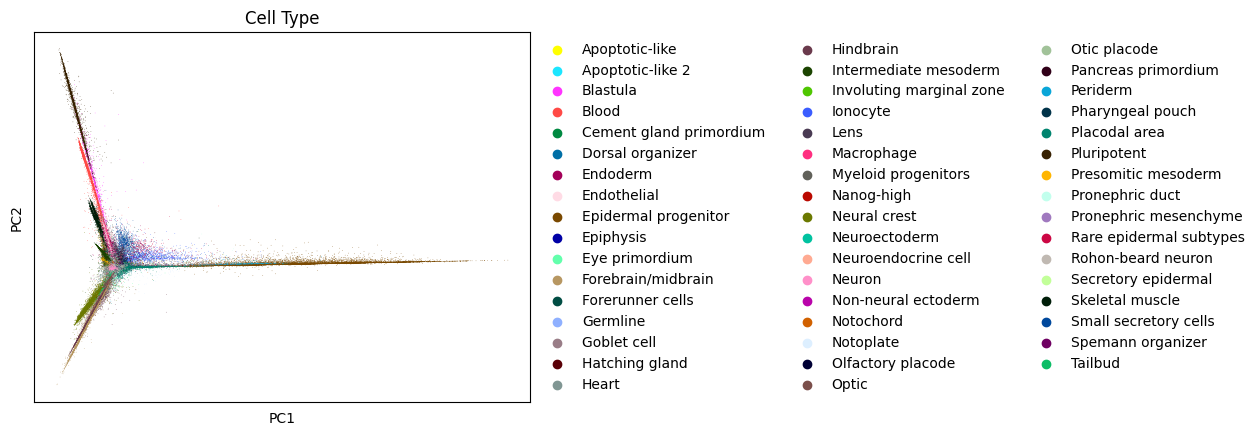

In [11]:
sc.pl.pca(adata, color="species", title="Species")
sc.pl.pca(adata, color="labels2", title="Cell Type") # The original cell type names

In [12]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

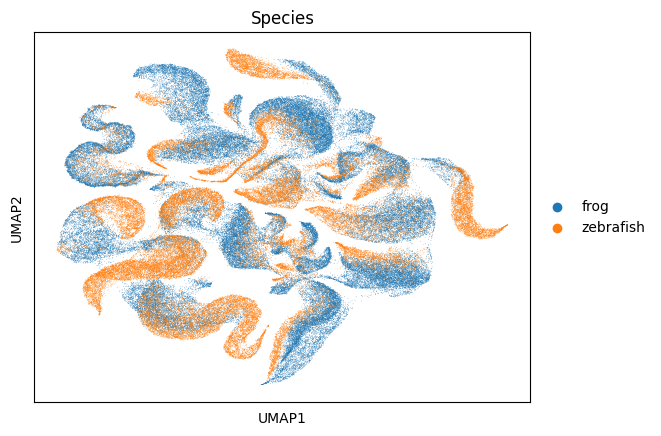

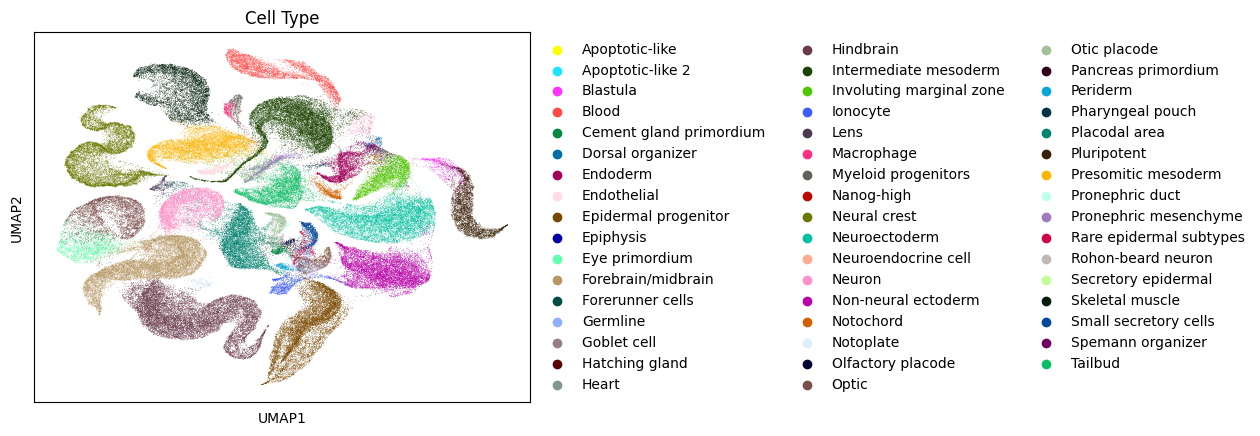

In [13]:
sc.pl.umap(adata, color="species", title="Species")
sc.pl.umap(adata, color="labels2", title="Cell Type")

# Macrogene Differential Expression

With SATURN, we can perform differential expression on macrogenes rather than genes.

In [14]:
with open("saturn_results/test256_data_frog_zebrafish_org_saturn_seed_0_genes_to_macrogenes.pkl", "rb") as f:
    macrogene_weights = pickle.load(f)

In [15]:
# macrogene weights is a dictionary of (species_{gene name}) : [gene to macrogen weight](1x2000)
macrogene_weights

{'frog_42Sp43': array([3.3450485e-06, 3.7223395e-05, 8.7116621e-07, ..., 6.6185015e-07,
        9.7744703e-07, 1.7868063e-06], dtype=float32),
 'frog_42Sp50': array([2.225002e-06, 4.929808e-05, 4.258304e-07, ..., 4.575007e-07,
        1.201823e-06, 9.106379e-07], dtype=float32),
 'frog_MGC107841': array([3.0998808e-06, 2.0053810e-04, 1.3109471e-06, ..., 6.8300801e-07,
        1.1856517e-06, 9.8161809e-07], dtype=float32),
 'frog_MGC107884': array([3.9500928e-06, 7.0711729e-05, 5.0007168e-07, ..., 6.5461739e-07,
        1.0145422e-06, 4.5317174e-07], dtype=float32),
 'frog_MGC107908': array([2.3676735e-06, 1.6502784e-04, 6.2111303e-07, ..., 5.4686154e-07,
        9.6391068e-07, 6.4638215e-07], dtype=float32),
 'frog_MGC108147': array([9.0898966e-06, 7.3681658e-05, 4.6964348e-07, ..., 5.4452175e-07,
        1.4153349e-06, 7.2334501e-07], dtype=float32),
 'frog_MGC108429': array([1.3675706e-06, 1.2638948e-03, 7.1510124e-07, ..., 5.1789738e-07,
        9.2061509e-07, 5.8272150e-07], dtype=

In [16]:
# Create a copy of the adata with macrogenes as the X values
macrogene_adata = sc.AnnData(adata.obsm["macrogenes"])
macrogene_adata.obs = adata.obs

In [17]:
sc.tl.rank_genes_groups(macrogene_adata, groupby="labels2", groups=["Ionocyte"], method="wilcoxon")

         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: Apoptotic-like, Apoptotic-like 2, Blastula, etc.
var_group_labels: Ionocyte


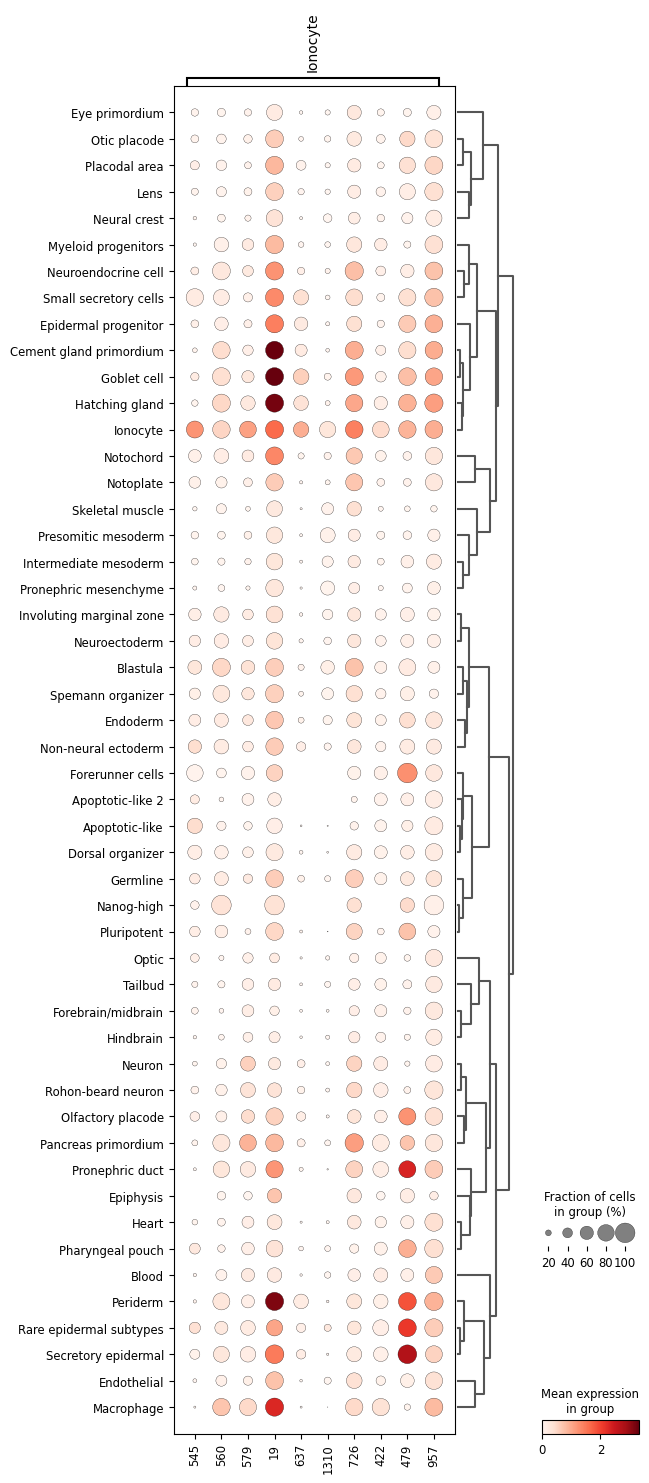

In [18]:
sc.pl.rank_genes_groups_dotplot(macrogene_adata)

In [19]:
ionocytes_de_df = sc.get.rank_genes_groups_df(macrogene_adata, group="Ionocyte").head(5)
ionocytes_de_df

,names,scores,logfoldchanges,pvals,pvals_adj
0,545,47.305073,4.609873,0.0,0.0
1,560,43.162769,2.918924,0.0,0.0
2,579,42.034676,3.808290,0.0,0.0
3,19,41.728745,2.710125,0.0,0.0
4,637,40.367966,4.848528,0.0,0.0


## Investigate these macrogenes by their top ranked genes

In [20]:
def get_scores(macrogene):
    '''
    Given the index of a macrogene, return the scores by gene for that centroid
    '''
    scores = {}
    for (gene), score in macrogene_weights.items():
        scores[gene] = score[int(macrogene)]
    return scores

In [21]:
# Display the top macrogenes and their highest weights
# NOTE: this will be seed dependent.
for macrogene in ionocytes_de_df["names"]:
    print(f"Macrogene {macrogene}")
    display(pd.DataFrame(get_scores(macrogene).items(), columns=["gene", "weight"])\
            .sort_values("weight", ascending=False)\
            .head(10))

Macrogene 545


,gene,weight
10240,zebrafish_foxi1,1.523459
10242,zebrafish_foxi3a,1.498498
2566,frog_foxi1,1.361709
2569,frog_foxi4.2,1.319814
2567,frog_foxi2,1.109046
10236,zebrafish_foxg1b,0.761884
10239,zebrafish_foxh1,0.647830
2564,frog_foxh1,0.439742
10249,zebrafish_foxn4,0.376648
2563,frog_foxg1,0.337112


Macrogene 560


,gene,weight
13134,zebrafish_rhbdl2,0.872764
14336,zebrafish_slc35d3,0.634712
6370,frog_slc35b3,0.601390
14339,zebrafish_slc35f6,0.567398
6375,frog_slc35e1,0.506874
14998,zebrafish_tmem163b,0.502985
14338,zebrafish_slc35f4,0.474718
14335,zebrafish_slc35d1a,0.459607
6361,frog_slc30a5,0.435587
4587,frog_nipal3,0.422937


Macrogene 579


,gene,weight
626,frog_atp6v0c,1.363616
8527,zebrafish_atp6v0cb,0.992663
8526,zebrafish_atp6v0ca,0.634819
625,frog_atp6v0b,0.467056
8525,zebrafish_atp6v0b,0.158816
6106,frog_sec61g,0.002751
1394,frog_cnih1,0.001928
2095,frog_eif1ax,0.000605
3922,frog_lsm2,0.000505
2096,frog_eif1b,0.000484


Macrogene 19


,gene,weight
12687,zebrafish_pmelb,0.840847
14985,zebrafish_tmem130,0.836953
8675,zebrafish_bscl2l,0.799814
12686,zebrafish_pmela,0.768585
6108,frog_sel1l3,0.756867
13983,zebrafish_si:dkey-251i10.2,0.742524
4570,frog_ngf,0.737634
15220,zebrafish_tspan10,0.672413
607,frog_atp13a-like,0.648522
6966,frog_tctn1,0.602282


Macrogene 637


,gene,weight
7499,frog_ubp1,1.397955
2963,frog_grhl1,1.211652
10599,zebrafish_grhl3,1.060354
2965,frog_grhl3,0.999543
10598,zebrafish_grhl2a,0.968703
9245,zebrafish_cnrip1a,0.960189
1412,frog_cnrip1,0.691489
2964,frog_grhl2,0.434679
14895,zebrafish_tfcp2l1,0.361716
10597,zebrafish_grhl1,0.354341
